In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        """



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        "

## AÇIKLAMALAR

# Train ve Test Veri Setleri

* merchant_id Maskelenmiş iş yeri ID'si

* month_id İşlemin yapıldığı ay (YYYYMM formatında)

* merchant_source İş yerinin iyzico’ya katıldığı kaynak

* settlement_period İş yerinin hak edişini alış sıklığı

* working_type İş yerinin tipini gösterir

* mcc_id İş yerinin satış yaptığı kategori bilgisini gösterir

* merchant_segment İş yerinin iyzico içerisinde bulunduğu segmenti gösterir

* net_payment_count İş yerinin ilgili ay içerisinde geçirdiği net (ödeme - iptal - iade) işlem sayısıdır

# Submission Dosyası

* id Tahminlenmesi beklenen ay ve maskelenmiş müşteri ID'si (Örn: 202312merchant_36004)

* net_payment_count İş yerinin ilgili ay geçirdiği işlem sayısı

# Dış Veri Kullanımı

Dönemsel enflasyon verisi, maaş ödenme günleri, (SGK ve devlet memurlarının maaş günleri vb…), resmi ve dini bayramlara ilişkin veriler, döviz kurları, mevsime göre ülkemizde görülen ortalama sıcaklık verileri gibi modelin kurulumunda size faydalı olabileceğini düşündüğünüz her türlü dış veriyi kullanabilirsiniz.


In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns

2024-01-28 03:01:30.851301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [37]:
"""
sample_submission = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")
base_train = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
"""

sample_submission = pd.read_csv("sample_submission.csv")
base_train = pd.read_csv("train.csv")

In [39]:
res = sample_submission.copy()
df = base_train.copy()

res[['month_id', 'merchant_id']] = res['id'].str.extract(r'(\d{6})(merchant_\d+)')
res

,id,net_payment_count,month_id,merchant_id
0,202311merchant_36004,0,202311,merchant_36004
1,202312merchant_36004,0,202312,merchant_36004
2,202310merchant_36004,0,202310,merchant_36004
3,202311merchant_23099,0,202311,merchant_23099
4,202312merchant_23099,0,202312,merchant_23099
...,...,...,...,...
78175,202312merchant_35969,0,202312,merchant_35969
78176,202310merchant_35969,0,202310,merchant_35969
78177,202311merchant_8429,0,202311,merchant_8429
78178,202312merchant_8429,0,202312,merchant_8429


In [40]:
df['month_id'] = pd.to_datetime(df['month_id'], format='%Y%m')
df.set_index('month_id', inplace=True)
res['month_id'] = pd.to_datetime(res['month_id'], format='%Y%m')
res.set_index('month_id', inplace=True)
res

,id,net_payment_count,merchant_id
month_id,,,
2023-11-01,202311merchant_36004,0,merchant_36004
2023-12-01,202312merchant_36004,0,merchant_36004
2023-10-01,202310merchant_36004,0,merchant_36004
2023-11-01,202311merchant_23099,0,merchant_23099
2023-12-01,202312merchant_23099,0,merchant_23099
...,...,...,...
2023-12-01,202312merchant_35969,0,merchant_35969
2023-10-01,202310merchant_35969,0,merchant_35969
2023-11-01,202311merchant_8429,0,merchant_8429


In [41]:
def plot_payment_count_forecast(df, res, merchant_id):
    # Filter the DataFrame for a specific 'merchant_id'
    df_x = df[df['merchant_id'] == merchant_id]
    res_x = res[res['merchant_id'] == merchant_id]

    # Plotting the original data
    df_x['net_payment_count'].plot(figsize=(10, 6))
    plt.title('Net Payment Count Over Time')
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')

    # Fit the ARIMA model
    model = ARIMA(df_x['net_payment_count'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting future points
    forecast_result = model_fit.get_forecast(steps=3)
    forecast = forecast_result.predicted_mean

    # Update res_x with forecasted values
    res_x.loc[res_x.index[:3], 'net_payment_count'] = list(forecast)

    # Plotting the forecasted points
    res_x['net_payment_count'].plot(style='r')

    
    plt.show()

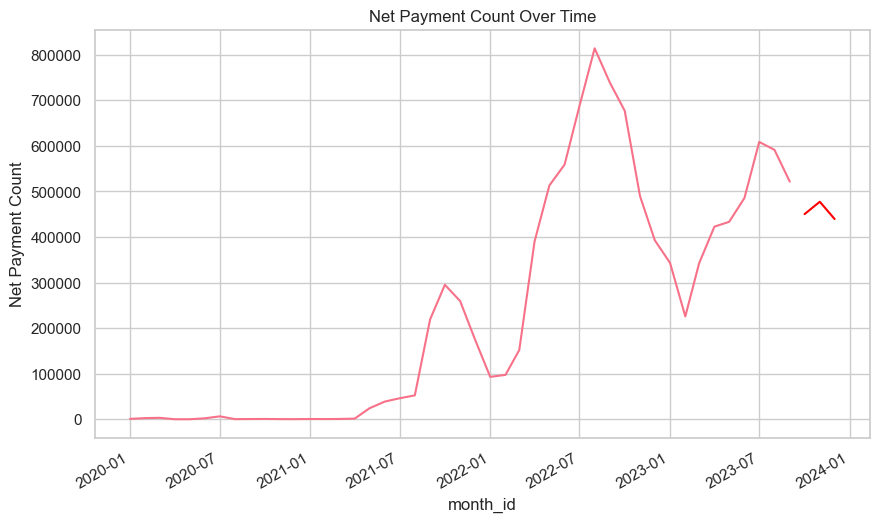

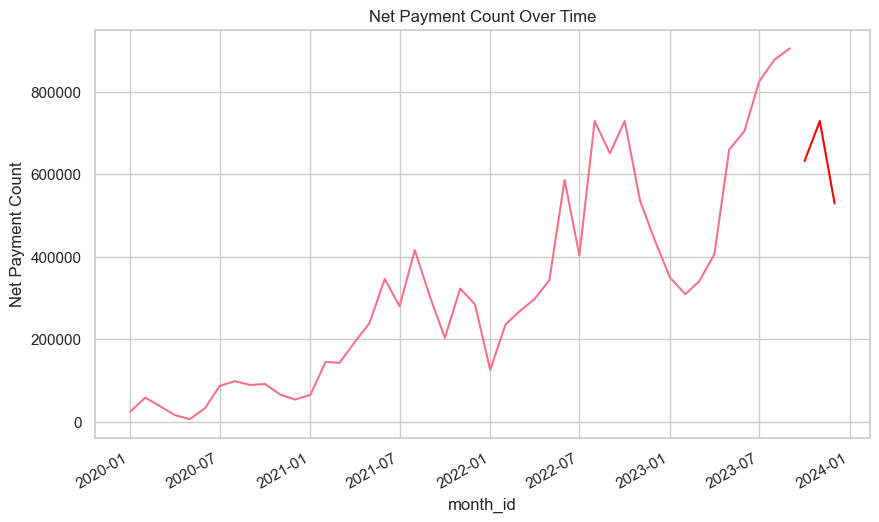

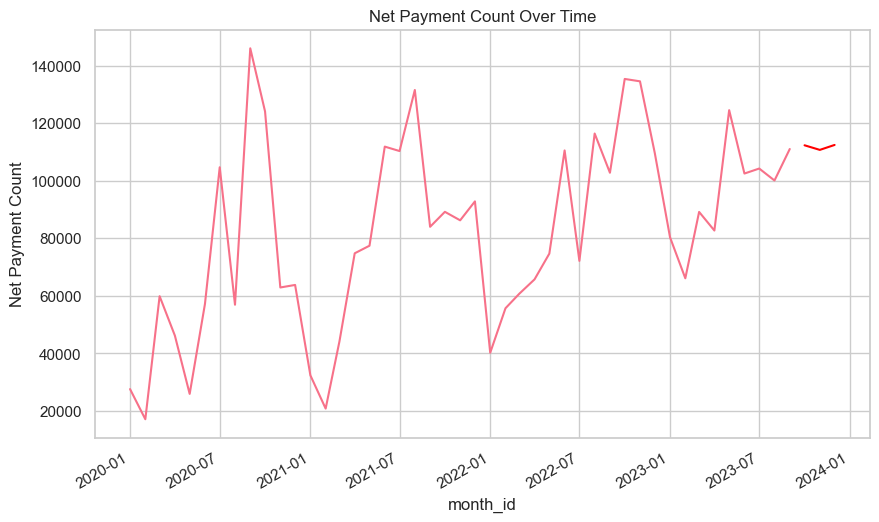

In [46]:
plot_payment_count_forecast(df, res, 'merchant_33179')
plot_payment_count_forecast(df, res, 'merchant_41628')
plot_payment_count_forecast(df, res, 'merchant_16119')


Getting month_id and merchant_id info from id in sample_submission

In [7]:
sample_submission

,id,net_payment_count
0,202311merchant_36004,0
1,202312merchant_36004,0
2,202310merchant_36004,0
3,202311merchant_23099,0
4,202312merchant_23099,0
...,...,...
78175,202312merchant_35969,0
78176,202310merchant_35969,0
78177,202311merchant_8429,0
78178,202312merchant_8429,0


In [22]:
samsub = sample_submission.copy()
train_data = base_train.copy()

samsub[['month_id', 'merchant_id']] = samsub['id'].str.extract(r'(\d{6})(merchant_\d+)')

# Sort the DataFrame by 'merchant_id' and 'month_id' in descending order
df_sorted = train_data.sort_values(by=['merchant_id', 'month_id'], ascending=[True, False])

# Group by 'merchant_id' and keep the first row of each group
latest_data = df_sorted.groupby('merchant_id').first().reset_index()

result = pd.merge(samsub, latest_data, on='merchant_id', how='left')
result

,id,net_payment_count_x,month_id_x,merchant_id,month_id_y,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count_y
0,202311merchant_36004,0,202311,merchant_36004,202210,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_144,Segment - 4,3
1,202312merchant_36004,0,202312,merchant_36004,202210,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_144,Segment - 4,3
2,202310merchant_36004,0,202310,merchant_36004,202210,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_144,Segment - 4,3
3,202311merchant_23099,0,202311,merchant_23099,202307,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_3,Segment - 4,3
4,202312merchant_23099,0,202312,merchant_23099,202307,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_3,Segment - 4,3
...,...,...,...,...,...,...,...,...,...,...,...
78175,202312merchant_35969,0,202312,merchant_35969,202208,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_110,Segment - 4,3
78176,202310merchant_35969,0,202310,merchant_35969,202208,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_110,Segment - 4,3
78177,202311merchant_8429,0,202311,merchant_8429,202111,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_42,Segment - 4,3
78178,202312merchant_8429,0,202312,merchant_8429,202111,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_42,Segment - 4,3


In [25]:
# Ignoring small values and churned customers
result.loc[(result['net_payment_count_y'] < 5) | (result['month_id_y'] < 202309), 'net_payment_count_x'] = 0

In [26]:
# Get the latest data for baseline
result.loc[~((result['net_payment_count_y'] < 5) | (result['month_id_y'] < 202309)), 'net_payment_count_x'] = result['net_payment_count_y']

In [28]:
ids= result[result['net_payment_count_x']!=0]['merchant_id'].unique()
train_data['month_id'] = pd.to_datetime(train_data['month_id'], format='%Y%m')
train_data.set_index('month_id', inplace=True)

In [29]:
train_data

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
month_id,,,,,,,
2023-07-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
2023-01-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2023-05-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
2023-08-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
2023-02-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...
2023-09-01,merchant_67083,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
2023-09-01,merchant_4263,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
2023-09-01,merchant_11346,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3


In [33]:
from numpy.linalg import LinAlgError

for id in tqdm(ids):
  train_data_t = train_data[train_data['merchant_id'] == id]
  # Check if there is sufficient data to fit the model
  if len(train_data_t) > 3:
    try:
      model = ARIMA(train_data_t['net_payment_count'], order=(1, 1, 1))
      model_fit = model.fit()
      forecast_result = model_fit.get_forecast(steps=3)
      forecast = forecast_result.predicted_mean
      filtered_res = result[result['merchant_id']==id].sort_values(by='month_id_x')['net_payment_count_x']
      result.loc[filtered_res.index[:3], 'net_payment_count_x'] = list(forecast)
    except LinAlgError:
        print(f"Linear algebra error for merchant_id {id}")
    except Exception as e:
        print(f"Error fitting model for merchant_id {id}: {e}")

  2%|▋                                        | 70/4383 [00:03<04:02, 17.79it/s]

Linear algebra error for merchant_id merchant_4948


  4%|█▋                                      | 186/4383 [00:10<04:14, 16.52it/s]

Linear algebra error for merchant_id merchant_16903


 27%|██████████▍                            | 1177/4383 [01:05<02:53, 18.48it/s]

Linear algebra error for merchant_id merchant_46943


 52%|████████████████████▍                  | 2300/4383 [02:09<01:48, 19.23it/s]

Linear algebra error for merchant_id merchant_21637


 59%|███████████████████████                | 2593/4383 [02:26<01:34, 19.03it/s]

Linear algebra error for merchant_id merchant_60230


100%|███████████████████████████████████████| 4383/4383 [04:15<00:00, 17.17it/s]


In [34]:
columns_to_keep = ['id', 'net_payment_count_x']
result = result[columns_to_keep]

# Rename 'net_payment_count_x' to 'net_payment_count'
result = result.rename(columns={'net_payment_count_x': 'net_payment_count'})

result

,id,net_payment_count
0,202311merchant_36004,0.0
1,202312merchant_36004,0.0
2,202310merchant_36004,0.0
3,202311merchant_23099,0.0
4,202312merchant_23099,0.0
...,...,...
78175,202312merchant_35969,0.0
78176,202310merchant_35969,0.0
78177,202311merchant_8429,0.0
78178,202312merchant_8429,0.0


In [36]:
result.net_payment_count.unique()

array([ 0.        , 24.5687074 , 24.56870924, ..., 11.48586404,
       11.53827448, 11.99765431])

In [35]:
# Save to CSV to submit
result.to_csv('submitMe.csv', index=False)

train_df

In [8]:
base_train

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...,...
291137,merchant_67083,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3


In [9]:
base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  object
 1   month_id              291142 non-null  int64 
 2   merchant_source_name  291142 non-null  object
 3   settlement_period     291142 non-null  object
 4   working_type          291142 non-null  object
 5   mcc_id                291142 non-null  object
 6   merchant_segment      291142 non-null  object
 7   net_payment_count     291142 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 17.8+ MB


In [10]:
base_train.describe()

,month_id,net_payment_count
count,291142.000000,2.911420e+05
mean,202159.680860,4.153842e+02
std,104.214948,1.082067e+04
min,202001.000000,-1.433000e+03
25%,202103.000000,4.000000e+00
50%,202201.000000,6.000000e+00
75%,202211.000000,1.400000e+01
max,202309.000000,1.160429e+06


In [11]:
print(f"Unique values for merchant id {base_train['merchant_id'].nunique()}")
print(f"Unique values for month id {base_train['month_id'].nunique()}")
print(f"Unique values for merchant_source_name {base_train['merchant_source_name'].nunique()}")
print(f"Unique values for settlement_period {base_train['settlement_period'].nunique()}")
print(f"Unique values for working_type {base_train['working_type'].nunique()}")
print(f"Unique values for mcc_id {base_train['mcc_id'].nunique()}")
print(f"Unique values for merchant_segment {base_train['merchant_segment'].nunique()}")
print(f"Unique values for net_payment_count {base_train['net_payment_count'].nunique()}")





Unique values for merchant id 26060
Unique values for month id 45
Unique values for merchant_source_name 3
Unique values for settlement_period 3
Unique values for working_type 6
Unique values for mcc_id 172
Unique values for merchant_segment 4
Unique values for net_payment_count 5039


In [12]:
# Example preprocessing (modify as needed)
cluster_data = base_train.copy() # Remove unnecessary columns
cluster_data = pd.get_dummies(cluster_data, columns= ["working_type", "merchant_segment", "merchant_source_name", "settlement_period"])  # One-hot encode categorical variables if necessary
cluster_data

,merchant_id,month_id,mcc_id,net_payment_count,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
0,merchant_43992,202307,mcc_197,15106,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
1,merchant_43992,202301,mcc_197,16918,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2,merchant_43992,202305,mcc_197,13452,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
3,merchant_43992,202308,mcc_197,16787,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
4,merchant_43992,202302,mcc_197,12428,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291137,merchant_67083,202309,mcc_169,4,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False
291138,merchant_4263,202309,mcc_73,4,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False
291139,merchant_11346,202309,mcc_169,3,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False
291140,merchant_21397,202309,mcc_168,3,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False


In [13]:
for column in base_train.columns:
    print(base_train[column].value_counts())

merchant_id
merchant_43992    45
merchant_19380    45
merchant_1100     45
merchant_17200    45
merchant_65293    45
                  ..
merchant_3063      1
merchant_35756     1
merchant_50399     1
merchant_56272     1
merchant_66895     1
Name: count, Length: 26060, dtype: int64
month_id
202112    7413
202303    7367
202203    7332
202305    7327
202308    7315
202309    7287
202204    7244
202307    7217
202201    7210
202301    7198
202304    7191
202212    7153
202111    7129
202211    7086
202210    7073
202205    7072
202306    7065
202202    7064
202105    7045
202206    7040
202109    7021
202110    7018
202106    7004
202209    6967
202103    6883
202104    6878
202208    6876
202302    6804
202108    6771
202207    6648
202102    6607
202107    6490
202101    6437
202012    6352
202011    5887
202010    5654
202009    5489
202008    5224
202007    4990
202006    4920
202005    4707
202004    4120
202003    3951
202002    3867
202001    3749
Name: count, dtype: int64
mercha

TIME SERIES ANALYSIS

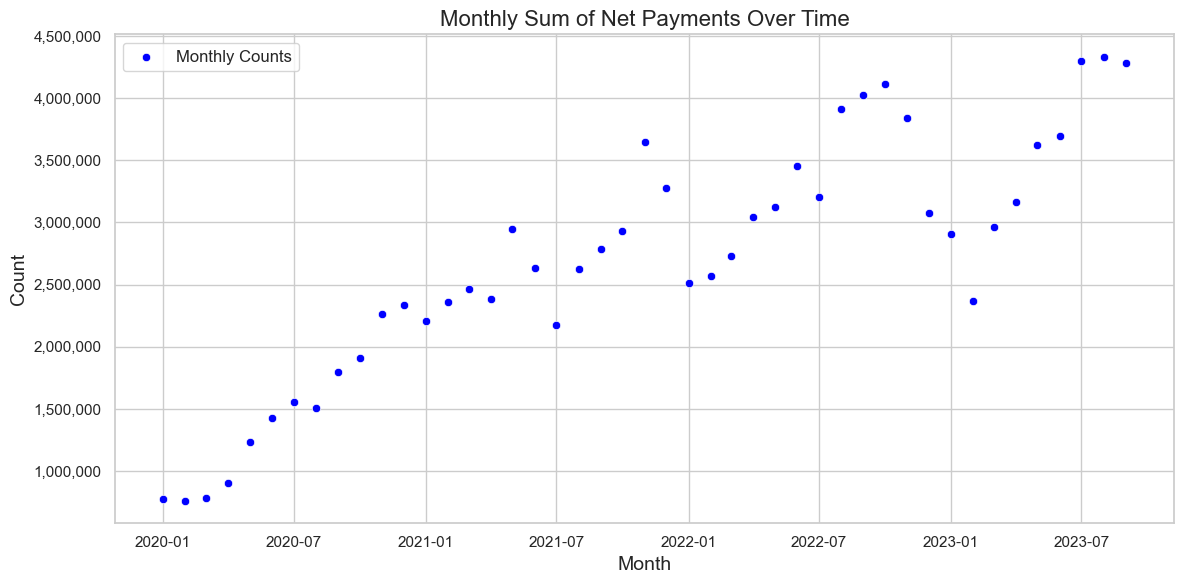

In [19]:
from matplotlib.ticker import FuncFormatter

# Assuming data is already loaded and processed as described in your code
data = base_train.copy()
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y%m')

# Group by month_id and sum the net_payment_count for each month
monthly_counts = data.groupby('month_id')['net_payment_count'].sum()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=monthly_counts.reset_index(), x='month_id', y='net_payment_count', color='blue', label='Monthly Counts')

# Apply the formatting function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


In [21]:
monthly_counts

month_id
2020-01-01     775289
2020-02-01     759571
2020-03-01     784726
2020-04-01     906968
2020-05-01    1234374
2020-06-01    1424606
2020-07-01    1559296
2020-08-01    1508304
2020-09-01    1801105
2020-10-01    1907334
2020-11-01    2263692
2020-12-01    2335235
2021-01-01    2204802
2021-02-01    2358530
2021-03-01    2464850
2021-04-01    2388236
2021-05-01    2948518
2021-06-01    2636933
2021-07-01    2172452
2021-08-01    2625566
2021-09-01    2787039
2021-10-01    2934176
2021-11-01    3646847
2021-12-01    3275615
2022-01-01    2509716
2022-02-01    2568446
2022-03-01    2730111
2022-04-01    3042259
2022-05-01    3122160
2022-06-01    3453755
2022-07-01    3203420
2022-08-01    3909944
2022-09-01    4021619
2022-10-01    4111855
2022-11-01    3842774
2022-12-01    3075363
2023-01-01    2910984
2023-02-01    2368511
2023-03-01    2967131
2023-04-01    3161692
2023-05-01    3619637
2023-06-01    3694900
2023-07-01    4301209
2023-08-01    4333899
2023-09-01    4282338
N

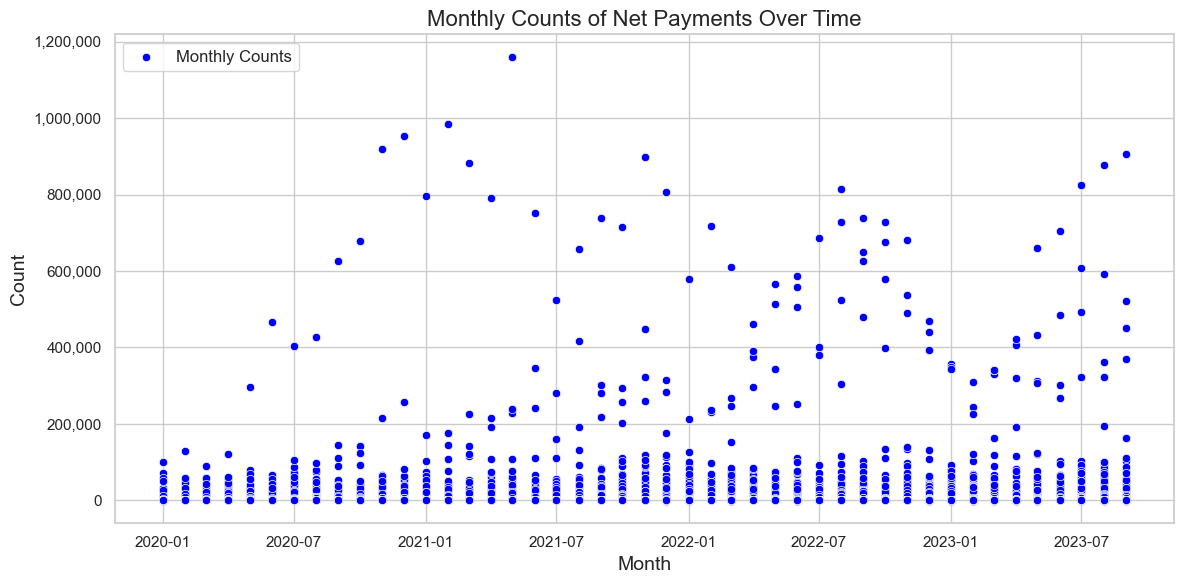

In [18]:
from matplotlib.ticker import FuncFormatter

# Assuming data is already loaded and processed as described in your code
data = base_train.copy()
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y%m')
data.set_index('month_id', inplace=True)

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=data, x=data.index, y='net_payment_count', color='blue', label='Monthly Counts')

# Apply the formatting function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Counts of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


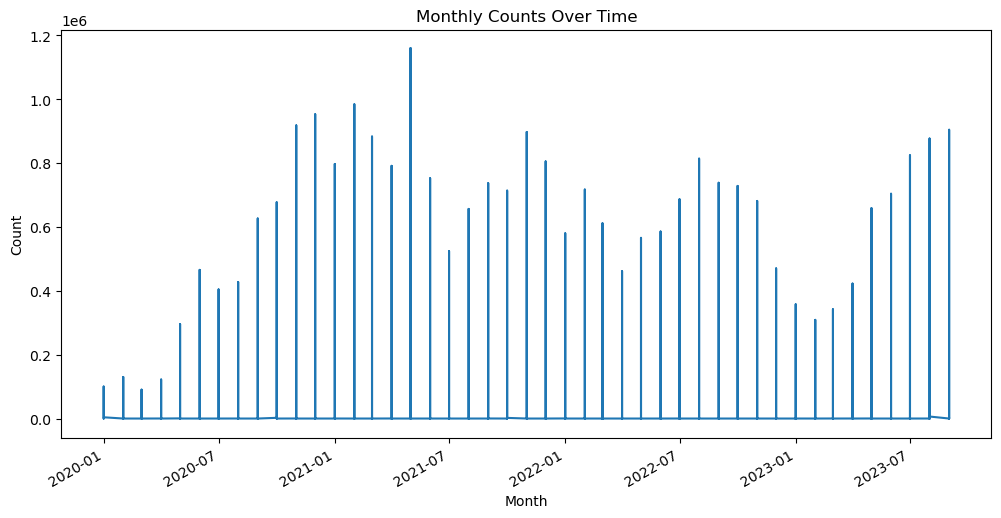

In [15]:
data = base_train.copy() # Remove unnecessary columns

data['month_id'] = pd.to_datetime(data['month_id'], format='%Y%m')
data.set_index('month_id', inplace=True)

data['net_payment_count'].plot(figsize=(12, 6))
plt.title('Monthly Counts Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


In [2]:
cluster_data
# Drop columns with high cardinality or low variance
columns_to_drop = ['merchant_id']
cluster_data = cluster_data.drop(columns=columns_to_drop)


NameError: name 'cluster_data' is not defined

In [ ]:
"""from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame
data_encoded = base_train.copy()

# One-Hot Encoding for low cardinality categorical variables
low_cardinality_cols = ['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']
data_encoded = pd.get_dummies(data_encoded, columns=low_cardinality_cols)

# Frequency Encoding for high cardinality categorical variables
high_cardinality_cols = ['merchant_id', 'month_id', 'mcc_id']
for column in high_cardinality_cols:
    freq_encoding = data_encoded[column].value_counts(normalize=True)
    data_encoded[column + '_freq'] = data_encoded[column].map(freq_encoding)

# Split the data into features (X) and target variable (y)
X = data_encoded.drop(columns=['net_payment_count'])
y = data_encoded['net_payment_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
"""

In [ ]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Assuming 'data' is your DataFrame
data_encoded = base_train.copy()

# Drop high cardinality columns
data_encoded = data_encoded.drop(columns=['merchant_id', 'month_id', 'mcc_id'])

# One-Hot Encoding for low cardinality categorical variables
low_cardinality_cols = ['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']
data_encoded = pd.get_dummies(data_encoded, columns=low_cardinality_cols)

# Target Encoding for high cardinality categorical variables
"""high_cardinality_cols = ['mcc_id']
target_encoder = TargetEncoder()
data_encoded[high_cardinality_cols] = target_encoder.fit_transform(data_encoded[high_cardinality_cols], data_encoded['net_payment_count'])
"""
# Split the data into features (X) and target variable (y)
X = data_encoded.drop(columns=['net_payment_count'])
y = data_encoded['net_payment_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# Optionally, you can also look at feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Multiply feature importances by 100 for percentage representation
feature_importances['Importance (%)'] = feature_importances['Importance'] * 100

# Print the feature and its importance percentage
print("\nFeature Importances (Percentage):\n")
for index, row in feature_importances.iterrows():
    print(f"{row['Feature']}: {row['Importance (%)']:.2f}%")





In [ ]:
# Display the feature importances
print("Feature Importances:")
print(feature_importances)

# Plotting the feature importances for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance (%)'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
sns.set(style="whitegrid")

# Set the size of the plot
plt.figure(figsize=(16, 8))

# Specify the columns to plot
columns_to_plot = ['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']

# Loop through each specified column and create count plots
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=column, data=base_train, palette="viridis")
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Assuming you have a DataFrame named 'data' with features and target variable
# For this example, let's assume 'net_payment_count' is the target variable
# Assuming 'data' is your DataFrame
data_encoded = base_train.copy()

# Drop high cardinality columns
data_encoded = data_encoded.drop(columns=['merchant_id', 'month_id', 'mcc_id'])

# Assuming 'net_payment_count' is your target variable
label_encoder = LabelEncoder()
data_encoded['net_payment_count'] = label_encoder.fit_transform(data_encoded['net_payment_count'])
print(data_encoded['net_payment_count'].unique())


# One-Hot Encoding for low cardinality categorical variables
low_cardinality_cols = ['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']
data_encoded = pd.get_dummies(data_encoded, columns=low_cardinality_cols)

# Target Encoding for high cardinality categorical variables
"""high_cardinality_cols = ['mcc_id']
target_encoder = TargetEncoder()
data_encoded[high_cardinality_cols] = target_encoder.fit_transform(data_encoded[high_cardinality_cols], data_encoded['net_payment_count'])
"""

# Select features and target variable
features = data_encoded.drop(columns=['net_payment_count'])
target = data_encoded['net_payment_count']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': len(data_encoded['net_payment_count'].unique()),  # Number of classes
    'eval_metric': 'mlogloss',  # Multi-logloss for multi-class problems
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10, verbose_eval=True)

# Make predictions on the test set
predictions = model.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_report_result = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report_result)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'net_payment_count' is your target variable
target_variable = "net_payment_count"

# Assuming 'cluster_data' is your DataFrame
cluster_data = pd.get_dummies(cluster_data)

# Selecting features (excluding the target variable)
X = cluster_data.drop(columns=[target_variable])
y = base_train[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_report_result = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report_result)


In [ ]:
# Assuming 'net_payment_count' is your target variable
target_variable = "net_payment_count"

# Selecting features (excluding the target variable)
cluster_data = cluster_data.drop(columns=[target_variable])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cluster_data, base_train[target_variable], test_size=0.2, random_state=42)

# Create a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_report_result = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report_result)


In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()